# **독버섯이 피어낸 검은 살의(殺意), 진실을 가려내라**

작성자: 김민채

## **프로젝트 목표**
가을 산행 시 속출하는 독버섯 중독 사고 예방을 위한 **독버섯 특성 분류** 프로젝트<br>
<br>

범인을 찾아라!


가을 맞이 등산을 떠난 민채 씨.  
단풍 명소의 저명답게 과연 형형색색의 가을 산새는 탄성을 자아냅니다.  
그런데 이때, 갑자기 산등성이를 울리는 찌를 듯한 비명소리에 모두 소스라치게 놀라게 되는데!  
웅성이는 사람들 속에서 거품을 물고 쓰러진 한 남자.  
빠르게 도착한 응급대원의 응급조치로 다행히 남자는 목숨을 잃지 않았습니다.  
그러나 현장 조사 결과 남자의 무리는 버섯을 캐러 다니는 심마니였고 4명 모두 남자에게 버섯을 권해 먹인 사실이 드러났습니다.  
용의선상에 오른 남자의 무리는 모두 독버섯 식별에 능통한 버섯 전문 심마니!   
본 사건은 단순 사고로 위장한 '살인미수사건'이 분명했습니다.  
자신이 권한 버섯은 독버섯이 아니라고 주장하는 가운데, 4명의 각 버섯 심마니는 자신이 먹인 버섯을 증거물로 제출했습니다. 

### **등산객 중 유일한 Data Scientist 인 민채 씨,**  
### 당신은 **머신러닝모델로 독버섯과 상관관계가 높은 특징을 반드시 찾아내** 이 사건을 해결해야 합니다.  
#### **과연 누가 남자를 독살하려 한 것일까?** 거짓은 통하지 않는다! 진실을 밝혀내라!  

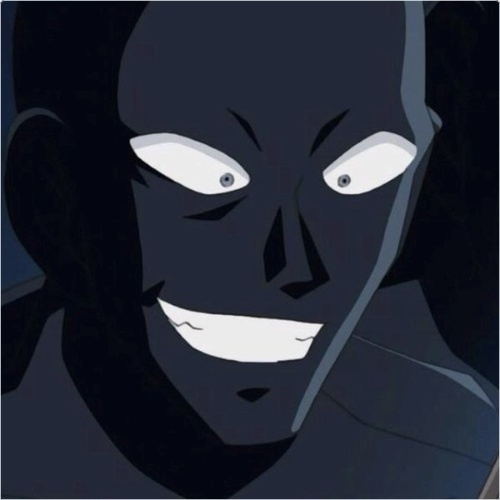

## **프로젝트 가설**
**주제**:<br>
통계적 머신 러닝 모델을 통한 독버섯 특성 분류 구조 수립<br>
<br> 

**귀무가설**:<br>
식용 버섯과 독버섯을 구별하는 주요 특성은 없다.<br>
<br>


**가설 검증 방향**:<br>
1. 버섯 특성 변수를 통한 분류 모델 형성
- 최적의 모델 구현: Tree 기반 모델
  - sklearn의 RandomForestClassifier 적용
  - sklearn의 XGBClassifier 적용<br>
<br>
2. 모델 알고리즘에 의한 특성 중요도 파악
- eli5.sklearn의 permutation Importance 적용<br>
<br>
3. 특성 중요도가 반영된 최종 모델 구성<br>
<br>
4. 선택된 주요 특성이 독버섯 분류에 미치는 영향 확인
- PDPbox(python partial dependence plot toolbox) 적용
  - 1 feature PDP
  - 2 feature PDP<br>
<br>
5. 특성 변수의 기여도를 통한 최종 모델의 분류 예측 결과 설명
- SHAP(SHapley Additive exPlanations) 적용<br>







## **환경설정**

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab    
    !pip install matplotlib==3.1.3
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install PDPbox
    !pip install shap

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [2]:
### load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import eli5
from eli5.sklearn import PermutationImportance
import pdpbox
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
### auto resize
%matplotlib inline

In [4]:
### pandas display option float format
pd.options.display.float_format = '{:.2f}'.format

In [5]:
# ### install pandas profiling for description of df
# !pip install pandas-profiling==2.7.1
# from pandas_profiling import ProfileReport

In [6]:
### upload csv file method1
from google.colab import files
uploaded = files.upload()

Saving mushrooms.csv to mushrooms.csv


## **데이터셋**<br>
**mushrooms.csv**<br>
This dataset contains estimated data at the state and national level and was derived from the Summary Reporting System (SRS).<br>
These data reflect the estimates the FBI has traditionally included in its annual publications.<br>
the FBI's estimated crime totals for the nation and all 50 states, 1979 to current year available.<br>
[Mushroom Classification, Safe to eat or deadly poison?](https://www.kaggle.com/uciml/mushroom-classification?select=mushrooms.csv)<br>
<br>
## **특성**


- classes : 버섯 유형
  - (e = edible, p = poisonous)
- cap-shape : 버섯 갓 모양
  - (b = bell, c = conical, x = convex, f = flat, k = knobbed, s = sunken)
- cap-surface : 버섯 갓 표면
  - (f = fibrous, g = grooves, y = scaly, w = smooth)                                    
- cap-color : 버섯 갓 색상
  - (n = brown, b = buff, c = cinnamon, g = gray, r = green, p = pink, u = purple, e = red, w = white, y = yellow)               
- bruises : 멍/ 타박상 색상 여부
  - (t = bruises, f = no)
- odor : 버섯 냄새
  - (a = almond, l = anise, c = creosote, y = fishy, f = foul, m = musty, n = none, p = pungent, s = spicy)
- gill-attachment : 버섯 주름 부착 유형
  - (a = attached, d = descending, f = free, n = notched)
- gill-spacing : 버섯 주름 공간 간격
  - (c = close, w = crowded, d = distant)
- gill-size : 버섯 주름 크기
  - (b = broad, n = narrow)
- gill-color : 버섯 주름 색상
  - (k = black, n = brown, b = buff, h = chocolate, g = gray, r = green, o = orange, p = pink, u = purple, e = red, w = white, y = yellow)                   
- stalk-shape : 버섯 대 모양
  - (e = enlarging, t = tapering)      
- stalk-root : 버섯 대주머니 유형
  - (b = bulbous, c = club, u = cup, e = equal, z = rhizomorphs, r = rooted)
- stalk-surface-above-ring : 버섯 대 턱받이 윗부분 표면
  - (f = fibrous, y = scaly, k = silky, s = smooth)
- stalk-surface-below-ring : 버섯 대 턱받이 아랫부분 표면
  - (f = fibrous, y = scaly, k = silky, s = smooth)
- stalk-color-above-ring : 버섯 대 턱받이 윗부분 색상
  - (n = brown, b = buff, c = cinnamon, g = gray, o = orange, p = pink, e = red, w = white, y = yellow)
- stalk-color-below-ring : 버섯 대 턱받이 아랫부분 색상
  - (n = brown, b = buff, c = cinnamon, g = gray, o = orange, p = pink, e = red, w = white, y = yellow)
- veil-type : 버섯 그물 유형
  - (p = partial, u = universal)
- veil-color : 버섯 그물 색상
  - (n = brown, o = orange, w = white, y = yellow)
- ring-number : 버섯 턱받이 개수
  - (n = none, o = one, t = two)
- ring-type : 버섯 턱받이 유형
  - (c = cobwebby, e = evanescent, f = flaring, l = large, n = none, p = pendant, s = sheathing, z = zone)
- spore-print-color : 주름의 포자가 만든 색상
  - (k = black, n = brown, b = buff, h = chocolate, r = green, o = orange, u = purple, w = white, y = yellow)
- population : 개체 군집 유형
  - (a = abundant, c = clustered, n = numerous, s = scattered, v = several, y = solitary)
- habitat : 서식지
  - (g = grasses, l = leaves, m = meadows, p = paths, u = urban, w = waste, d = woods)


In [7]:
### load csv file

df = pd.read_csv('mushrooms.csv')

In [8]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [9]:
df.shape

(8124, 23)

In [10]:
# ### df description through by pandas_profile

# profile = ProfileReport(df)
# profile.to_file('mushroom_report.html')

In [11]:
df = df.replace('?', np.nan)

df.isnull().sum() / df.shape[0] * 100

class                       0.00
cap-shape                   0.00
cap-surface                 0.00
cap-color                   0.00
bruises                     0.00
odor                        0.00
gill-attachment             0.00
gill-spacing                0.00
gill-size                   0.00
gill-color                  0.00
stalk-shape                 0.00
stalk-root                 30.53
stalk-surface-above-ring    0.00
stalk-surface-below-ring    0.00
stalk-color-above-ring      0.00
stalk-color-below-ring      0.00
veil-type                   0.00
veil-color                  0.00
ring-number                 0.00
ring-type                   0.00
spore-print-color           0.00
population                  0.00
habitat                     0.00
dtype: float64

In [12]:
df = df.dropna(axis = 0)

In [13]:
df = df.reset_index(drop = True)

In [14]:
df.shape

(5644, 23)

## **가설검증**

### **1. 버섯 특성 변수를 통한 분류 모델 형성**
- 최적의 모델 구현: Tree 기반 모델
  - sklearn의 RandomForestClassifier 적용
  - sklearn의 XGBClassifier 적용

모델 형성 전 데이터셋의 target인 class를 살펴보았다.

In [15]:
### target = 'class'

df['class'].value_counts()

e    3488
p    2156
Name: class, dtype: int64

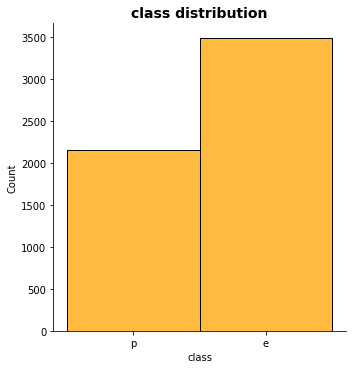

In [16]:
### target -> 시각화

sns.displot(df['class'], color = 'orange')
plt.title('class distribution', fontsize = 14, fontweight = 'bold')
plt.show()

class는 독버섯과 식용버섯의 분포가 크게 치우쳐지지 않은 편이었다.<br>


In [17]:
### high cardinality 확인

df.describe().T.sort_values(by = 'unique')

# high cardinality 로 볼 수 있는 features 는 없다.

,count,unique,top,freq
veil-type,5644,1,p,5644
class,5644,2,e,3488
veil-color,5644,2,w,5636
bruises,5644,2,t,3184
gill-attachment,5644,2,f,5626
gill-spacing,5644,2,c,4620
gill-size,5644,2,b,4940
stalk-shape,5644,2,t,2880
ring-number,5644,3,o,5488
ring-type,5644,4,p,3488


In [18]:
### encoding -> LabelEncoder

for col in df.columns:
  label_ec = LabelEncoder()
  df['class'] = label_ec.fit_transform(df['class'])

In [19]:
### check encoding

df['class']

0       1
1       0
2       0
3       1
4       0
       ..
5639    0
5640    0
5641    0
5642    1
5643    1
Name: class, Length: 5644, dtype: int64

In [20]:
### check

df['class'].value_counts() 

# '0' = 'e' | '1' = 'p'

0    3488
1    2156
Name: class, dtype: int64

#### **1) Baseline model**

In [21]:
# baseline model -> classification : majority category

baseline = [df['class'].mode()[0]] * len(df['class'])


baseline_accuracy = accuracy_score(df['class'], baseline)


print(f'baseline 검증 정확도는: ', baseline_accuracy)


# baseline model 은 약 60% 정확도로 'class'를 분류한다.

baseline 검증 정확도는:  0.6180014174344437


#### **2) Split dataset to train, val, test**

In [22]:
### split -> train, val, test

train, test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 74)

train, val = train_test_split(train, train_size = 0.7, random_state = 74)


train.shape, val.shape, test.shape

((2765, 23), (1185, 23), (1694, 23))

#### **3) Labels : features(X), target(y)**

In [23]:
### features(X), target(y)

target = 'class'

features = train.columns.drop(target)

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]


In [24]:
### check

X_train.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
1908,f,s,g,f,n,f,w,b,h,t,e,s,f,w,w,p,w,o,e,k,a,g
5328,f,s,g,t,f,f,c,b,h,t,b,f,s,w,w,p,w,o,p,h,v,g
1211,f,s,n,f,n,f,w,b,p,t,e,s,s,w,w,p,w,o,e,k,a,g
1954,x,f,n,t,n,f,c,b,p,t,b,s,s,p,g,p,w,o,p,k,v,d
4943,x,s,g,f,c,f,c,n,p,e,b,s,s,w,w,p,w,o,p,n,v,d


#### **4) Modeling**
- Make models : **evaluation metrics = 'accuracy'**
  - (1) RandomForestClassifier model
  - (2) XGBClassifier model
  - (3) compare each validation score and select one

(1) RandomForestClassifier model

In [25]:
### randomforestregressor model

pipe = make_pipeline(OrdinalEncoder(),
                     SimpleImputer(),
                     RandomForestClassifier(oob_score = True, n_jobs = -1, random_state = 74))



pipe.named_steps

{'ordinalencoder': OrdinalEncoder(cols=None, drop_invariant=False, handle_missing='value',
                handle_unknown='value', mapping=None, return_df=True, verbose=0),
 'randomforestclassifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=-1, oob_score=True, random_state=74, verbose=0,
                        warm_start=False),
 'simpleimputer': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
               missing_values=nan, strategy='mean', verbose=0)}

In [26]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['cap-shape', 'cap-surface', 'cap-color',
                                      'bruises', 'odor', 'gill-attachment',
                                      'gill-spacing', 'gill-size', 'gill-color',
                                      'stalk-shape', 'stalk-root',
                                      'stalk-surface-above-ring',
                                      'stalk-surface-below-ring',
                                      'stalk-color-above-ring',
                                      'stalk-color-below-ring', 'veil-type',
                                      'veil-color', 'ring-number',...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples

In [27]:
### validation score

print(f'oob accuracy score: ', pipe.named_steps['randomforestclassifier'].oob_score_)

print(f'validation accuracy score: ', pipe.score(X_val, y_val))

oob accuracy score:  1.0
validation accuracy score:  1.0


Baseline model 과 RandomForestClassifier model 검증 테스트 결과


- baseline socre = 0.6180014174344437

- RandomForestClassifier score 
 - oob accuracy score:  1.0  
 - validation accuracy score:  1.0

In [28]:
### test -> leakage check = no leakage

y_pred = pipe.predict(X_test)

test_score = accuracy_score(y_test, y_pred)


print(f'test accuracy score: ', test_score)

test accuracy score:  1.0


In [29]:
### classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1052
           1       1.00      1.00      1.00       642

    accuracy                           1.00      1694
   macro avg       1.00      1.00      1.00      1694
weighted avg       1.00      1.00      1.00      1694



(2) XGBClassifier model

In [30]:
### XGBClassifier model

pipe = make_pipeline(OrdinalEncoder(),
                     XGBClassifier(n_estimators = 200,
                                  learning_rate = 0.15,
                                  random_state = 74,
                                  n_jobs = -1))

In [31]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['cap-shape', 'cap-surface', 'cap-color',
                                      'bruises', 'odor', 'gill-attachment',
                                      'gill-spacing', 'gill-size', 'gill-color',
                                      'stalk-shape', 'stalk-root',
                                      'stalk-surface-above-ring',
                                      'stalk-surface-below-ring',
                                      'stalk-color-above-ring',
                                      'stalk-color-below-ring', 'veil-type',
                                      'veil-color', 'ring-number',...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.15,
                               max_delta_step=0, max_depth=3,
                  

In [32]:
### validation score

print(f'validation score는: ', pipe.score(X_val, y_val))

validation score는:  1.0


In [33]:
### early_stopping_round -> 과적합 피하기 

encoder = OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)

X_val_encoded = encoder.transform(X_val)


xgb_model = XGBClassifier(n_estimators = 200,
                                  learning_rate = 0.15,
                                  random_state = 74,
                                  n_jobs = -1)


eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]


xgb_model.fit(X = X_train_encoded, y = y_train, eval_set = eval_set, eval_metric = 'error', early_stopping_rounds = 43)

[0]	validation_0-error:0	validation_1-error:0
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 43 rounds.
[1]	validation_0-error:0	validation_1-error:0
[2]	validation_0-error:0	validation_1-error:0
[3]	validation_0-error:0	validation_1-error:0
[4]	validation_0-error:0	validation_1-error:0
[5]	validation_0-error:0	validation_1-error:0
[6]	validation_0-error:0	validation_1-error:0
[7]	validation_0-error:0	validation_1-error:0
[8]	validation_0-error:0	validation_1-error:0
[9]	validation_0-error:0	validation_1-error:0
[10]	validation_0-error:0	validation_1-error:0
[11]	validation_0-error:0	validation_1-error:0
[12]	validation_0-error:0	validation_1-error:0
[13]	validation_0-error:0	validation_1-error:0
[14]	validation_0-error:0	validation_1-error:0
[15]	validation_0-error:0	validation_1-error:0
[16]	validation_0-error:0	validation_1-error:0
[17]	validation_0-error:0	validation_1-error:0
[18

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=74,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [34]:
### 과적합 최소화 후 validation score

print(f'validation score는: ', xgb_model.score(X_val_encoded, y_val))

validation score는:  1.0


Baseline model 과 XGBClassifier model 검증 테스트 결과  


- baseline socre = 0.6180014174344437

- XGBClassifier score  
 - early_stopping_rounds 전 : 1.0
 - early_stopping_rounds 후(과적합 최소화) : 1.0

In [35]:
### test -> leakage check = no leakage 

X_test_encoded = encoder.transform(X_test)

y_pred = xgb_model.predict(X_test_encoded)

test_score = accuracy_score(y_test, y_pred)


print(f'test accuracy score: ', test_score)

test accuracy score:  1.0


In [36]:
### classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1052
           1       1.00      1.00      1.00       642

    accuracy                           1.00      1694
   macro avg       1.00      1.00      1.00      1694
weighted avg       1.00      1.00      1.00      1694



#### compare each model validation score and select one  
1) RandomForestClassifier model  
- 1.0  

2) XGBClassifier model   
- 1.0  


->> **결정 : XGBClassifier model**

### **2. 모델 알고리즘에 의한 특성 중요도 파악**
- eli5.sklearn의 permutation Importance 적용

In [37]:
permuter = PermutationImportance(xgb_model,
                                 scoring = 'accuracy',
                                 n_iter = 7,
                                 random_state = 74)


permuter.fit(X_val_encoded, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.15,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=200, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=74, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                  

In [38]:
feature_names = X_val.columns.tolist()

importances = pd.Series(permuter.feature_importances_, feature_names)


importances.sort_values(ascending = False)

odor                       0.46
bruises                    0.06
population                 0.03
spore-print-color          0.02
habitat                    0.00
stalk-shape                0.00
cap-surface                0.00
cap-color                  0.00
gill-attachment            0.00
gill-spacing               0.00
gill-size                  0.00
gill-color                 0.00
stalk-root                 0.00
stalk-surface-above-ring   0.00
stalk-surface-below-ring   0.00
stalk-color-above-ring     0.00
stalk-color-below-ring     0.00
veil-type                  0.00
veil-color                 0.00
ring-number                0.00
ring-type                  0.00
cap-shape                  0.00
dtype: float64

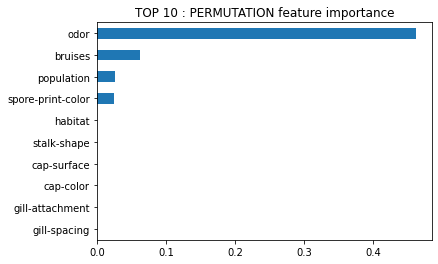

In [39]:
importances.sort_values()[-10:].plot.barh()

plt.title(label = 'TOP 10 : PERMUTATION feature importance')
plt.show()

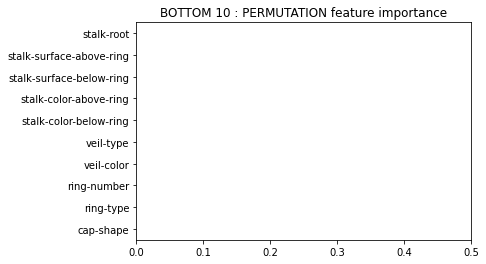

In [40]:
importances.sort_values()[:10].plot.barh()

plt.xlim((0.0, 0.5))
plt.title(label = 'BOTTOM 10 : PERMUTATION feature importance')
plt.show()

In [41]:
### score check depending on each feature

eli5.show_weights(estimator= permuter, top = None, feature_names = feature_names)

Weight,Feature
0.4622 ± 0.0215,odor
0.0617 ± 0.0085,bruises
0.0262 ± 0.0100,population
0.0250 ± 0.0020,spore-print-color
0 ± 0.0000,habitat
0 ± 0.0000,stalk-shape
0 ± 0.0000,cap-surface
0 ± 0.0000,cap-color
0 ± 0.0000,gill-attachment
0 ± 0.0000,gill-spacing


In [42]:
### PERMUTATION feature importance -> select features

min_importance = 0.001


condition = permuter.feature_importances_ > min_importance
features = X_train.columns[condition]

X_train_selected = X_train[features]
X_val_selected = X_val[features]
X_test_selected = X_test[features]

In [43]:
### before | after selecting features by PERMUTATION feature importance

print('before: ', X_train.shape, X_val.shape)
print('after: ', X_train_selected.shape, X_val_selected.shape)

before:  (2765, 22) (1185, 22)
after:  (2765, 4) (1185, 4)


### **3. 특성 중요도가 반영된 최종 모델 구성**

In [44]:
### final model

pipe = make_pipeline(OrdinalEncoder(),
                     XGBClassifier(n_estimators = 200,
                                  learning_rate = 0.15,
                                  random_state = 74,
                                  n_jobs = -1))


pipe.fit(X_train_selected, y_train);


encoder = pipe.named_steps['ordinalencoder']

X_train_encoded = encoder.fit_transform(X_train_selected)

X_val_encoded = encoder.transform(X_val_selected)

X_test_encoded = encoder.transform(X_test_selected)



xgb_model = pipe.named_steps['xgbclassifier']




eval_set = [(X_train_encoded, y_train),
            (X_val_encoded, y_val)]


xgb_model.fit(X = X_train_encoded, y = y_train, eval_set = eval_set, eval_metric = 'error', early_stopping_rounds = 43)

[0]	validation_0-error:0	validation_1-error:0
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 43 rounds.
[1]	validation_0-error:0	validation_1-error:0
[2]	validation_0-error:0	validation_1-error:0
[3]	validation_0-error:0	validation_1-error:0
[4]	validation_0-error:0	validation_1-error:0
[5]	validation_0-error:0	validation_1-error:0
[6]	validation_0-error:0	validation_1-error:0
[7]	validation_0-error:0	validation_1-error:0
[8]	validation_0-error:0	validation_1-error:0
[9]	validation_0-error:0	validation_1-error:0
[10]	validation_0-error:0	validation_1-error:0
[11]	validation_0-error:0	validation_1-error:0
[12]	validation_0-error:0	validation_1-error:0
[13]	validation_0-error:0	validation_1-error:0
[14]	validation_0-error:0	validation_1-error:0
[15]	validation_0-error:0	validation_1-error:0
[16]	validation_0-error:0	validation_1-error:0
[17]	validation_0-error:0	validation_1-error:0
[18

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=74,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [45]:
### final model validation score

xgb_model.score(X_val_encoded, y_val)

1.0

Baseline model 과 Final model 의 검증 테스트 결과

- baseline score = 0.6180014174344437
- final model : XGBClassifier model (applying selected features) 
  -  validation score : 1.0

In [46]:
### test data score

y_pred = xgb_model.predict(X_test_encoded)

test_score = accuracy_score(y_test, y_pred)


print(f'test accuracy score: ', test_score)

test accuracy score:  1.0


In [47]:
### classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1052
           1       1.00      1.00      1.00       642

    accuracy                           1.00      1694
   macro avg       1.00      1.00      1.00      1694
weighted avg       1.00      1.00      1.00      1694



### **4. 선택된 주요 특성이 독버섯 분류에 미치는 영향 확인**
- PDPbox(python partial dependence plot toolbox) 적용
  - 1 feature PDP
  - 2 feature PDP


tree model은 coefficients를 이용해 각 feature 와 target 간의 관계를 알아볼 수 없는 특징을 가지고 있다.  
따라서 PDPbox를 통해 이를 알아보겠다.

#### **1) 1 feature PDP**



(1) odor

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


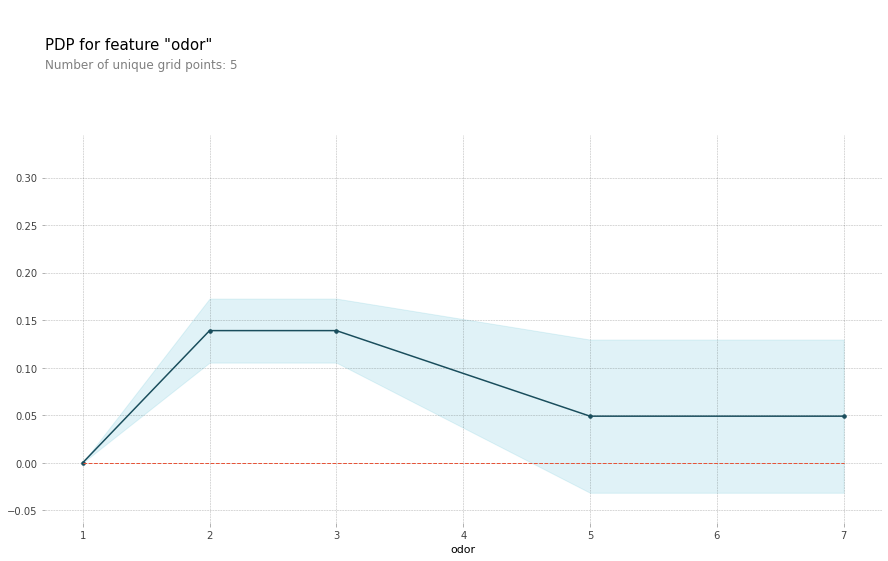

In [48]:
### PDP -> 1 feature

feature = 'odor'

isolated = pdp_isolate(model = xgb_model, dataset = X_val_encoded, model_features = X_val_encoded.columns, feature = feature)

pdp_plot(isolated, feature_name = feature)
plt.show()

카테고리형 특성은 인코딩에 의해 새로운 숫자가 부여되었다.<br>
따라서 각 숫자만으로는 어떤 의미인지 파악하기가 어려우므로 맵핑을 통해 짝지어진 본래 값을 파악해보겠다.<br>

In [49]:
### encoder mapping check

encoder.mapping

[{'col': 'bruises', 'data_type': dtype('O'), 'mapping': f      1
  t      2
  NaN   -2
  dtype: int64}, {'col': 'odor', 'data_type': dtype('O'), 'mapping': n      1
  f      2
  c      3
  p      4
  l      5
  a      6
  m      7
  NaN   -2
  dtype: int64}, {'col': 'spore-print-color',
  'data_type': dtype('O'),
  'mapping': k      1
  h      2
  n      3
  u      4
  w      5
  r      6
  NaN   -2
  dtype: int64}, {'col': 'population',
  'data_type': dtype('O'),
  'mapping': a      1
  v      2
  s      3
  y      4
  c      5
  n      6
  NaN   -2
  dtype: int64}]

직관적인 해석을 위해 맵핑에 의해 파악된 본래 값을 PDPbox에 반영해보겠다. 

In [50]:
### automatic encoder mapping

feature = 'odor'

for stuff in encoder.mapping:
  if stuff['col'] == feature:
    feature_mapping = stuff['mapping']


feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

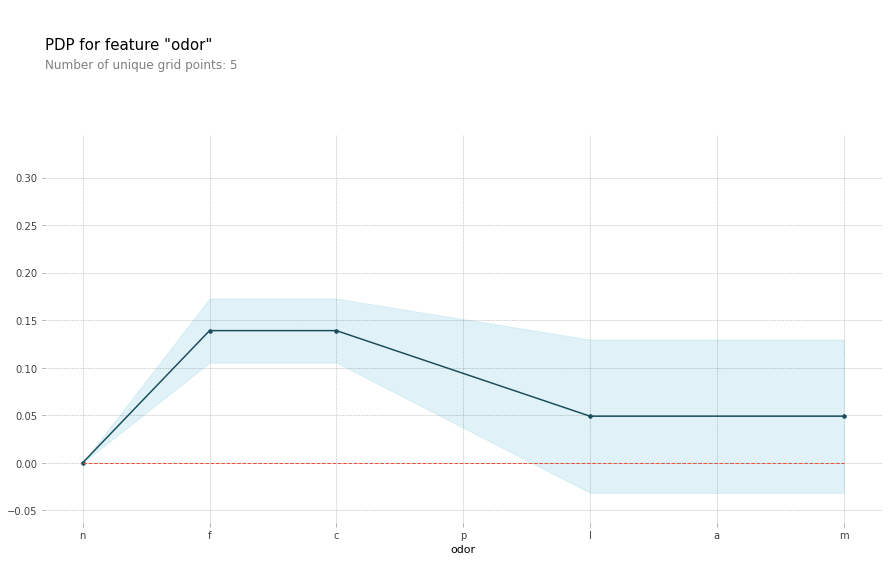

In [51]:
### automatic encoder mapping -> PDP 1 feature

pdp_plot(isolated, feature_name = feature)

plt.xticks(category_codes, category_names)
plt.show()

**해석**   
- odor : 버섯 냄새
  - (a = almond, l = anise, c = creosote, y = fishy, f = foul, m = musty, n = none, p = pungent, s = spicy)<br>  
<br>

odor 란 화학 작용으로 풍기는 냄새다. 보통 좋은 냄새보단 ‘불괘한 냄새’일 경우에 많이 표현된다.<br>
흔히 냄새로 독버섯을 구분할 수 있다고 하는데 완전히 틀린 말은 아니었다.<br>
무취인 버섯보다 자극적이거나 불쾌한 냄새가 나는 경우 독버섯일 확률이 높아졌기 때문이다.  
위 그래프를 보면 부패해 썩은 악취가 나는 foul odor와 역한 타르 냄새가 풍기는 creosote odor에서 독버섯 분류에 미치는 영향이 가장 컸다.<br>
한편 자극적일 정도로 톡 쏘는 냄새를 풍기는 pungent odor와 달콤하면서도 신 레몬향의 anise odor, 아몬드 향의 almond odd, 곰팡이 냄새인 musty odd에서도 독버섯이 될 확률이 작지만 존재했다.<br>  

다시말해 무취이거나 맡기 나쁘지 않은 냄새보단 다소 불쾌한 하고 자극적인 냄새가 강할수록 독버섯으로 분류될 확률이 컸다.






(2) bruises

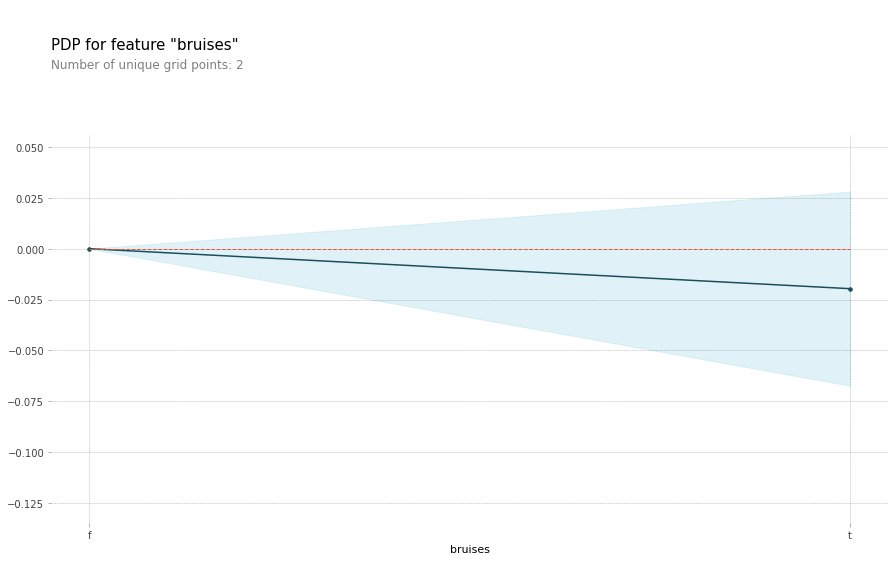

In [52]:
feature = 'bruises'


isolated = pdp_isolate(model = xgb_model, dataset = X_val_encoded, model_features = X_val_encoded.columns, feature = feature)


pdp_plot(isolated, feature_name = feature)



# automatic encoder mapping

feature = 'bruises'

for stuff in encoder.mapping:
  if stuff['col'] == feature:
    feature_mapping = stuff['mapping']


feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()


plt.xticks(category_codes, category_names)
plt.show()

**해석**   
- bruises : 멍/ 타박상 색상 여부
  - (t = bruises, f = no)<br>  
<br>

bruises란 버섯 분류 특성에 사용되는 것으로 타박상 혹은 멍으로 보이는 색상 여부를 말한다.<br>
특정 버섯은 외부 영향으로 손상될 시 독특한 색상을 띄곤 하기 때문이다.<br> 
그러나 타박상 혹은 멍으로 보이는 색상이 있을 경우 오히려 독버섯으로 분류될 확률이 감소하는 것으로 파악됐다.<br>






(3) population

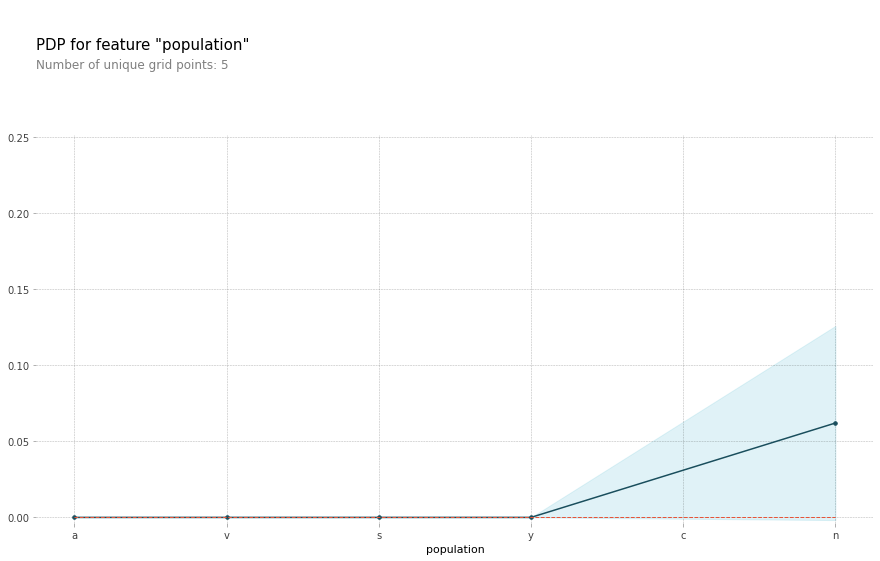

In [53]:
feature = 'population'


isolated = pdp_isolate(model = xgb_model, dataset = X_val_encoded, model_features = X_val_encoded.columns, feature = feature)


pdp_plot(isolated, feature_name = feature)



# automatic encoder mapping

feature = 'population'

for stuff in encoder.mapping:
  if stuff['col'] == feature:
    feature_mapping = stuff['mapping']


feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()


plt.xticks(category_codes, category_names)
plt.show()

**해석**   
- population : 개체 군집 유형
  - (a = abundant, c = clustered, n = numerous, s = scattered, v = several, y = solitary)<br>  
<br>

population이란 버섯 개체의 군집 유형을 의미한다.<br>
pdpbox 결과, 무리를 이뤄 자랄 경우 독버섯으로 분류될 확률이 높아지기 시작해 많은 군집을 이루어 자랄 경우 독버섯 분류에 가장 높은 영향을 끼쳤다.<br>






(4) spore-print-color

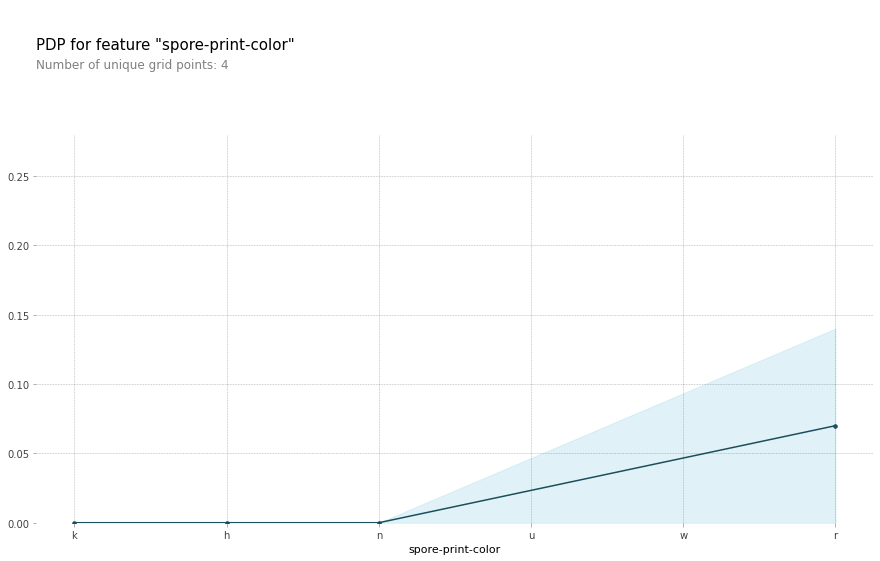

In [54]:
feature = 'spore-print-color'


isolated = pdp_isolate(model = xgb_model, dataset = X_val_encoded, model_features = X_val_encoded.columns, feature = feature)


pdp_plot(isolated, feature_name = feature)



# automatic encoder mapping

feature = 'spore-print-color'

for stuff in encoder.mapping:
  if stuff['col'] == feature:
    feature_mapping = stuff['mapping']


feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()


plt.xticks(category_codes, category_names)
plt.show()

**해석**  
- spore-print-color : 주름의 포자가 만든 색상
  - (k = black, n = brown, b = buff, h = chocolate, r = green, o = orange, u = purple, w = white, y = yellow)<br>  
<br>


spore-print-color 는 버섯 주름의 포자가 만든 색을 의미한다.  
버섯은 주름에 존재하는 spore-print-color 에 따라 구별될 수 있기 때문에 버섯 분류에서 중요한 요소로 꼽힌다.  
포자 프린트 색이 보라색, 하얀색, 초록색일수록 독버섯으로 분류될 확률이 높아졌다.<br> 
즉 한 눈에 사로잡힐 정도로 화려하거나 새하얀 버섯 포자 색을 가진 경우 독버섯일 확률이 컸다.

한 가지 특성의 독버섯 분류 영향력을 파악해본 결과, 
- 버섯 냄새가 불쾌하거나 자극적일수록
- 외부 손상 시 타박상 혹은 멍으로 보이는 색상이 없을 경우
- 무리를 이루거나 많은 군집을 이루어 자랄 경우 
- 포자색이 하얗거나 보다 화려할수록<br>

**독버섯으로 분류될 가능성이 높았다.**

#### **2) 2 features PDP**

두 가지의 특성 변수가 상호적으로 독버섯 분류에 끼치는 영향력은 다음과 같다.<br>

(1) odor - bruises

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


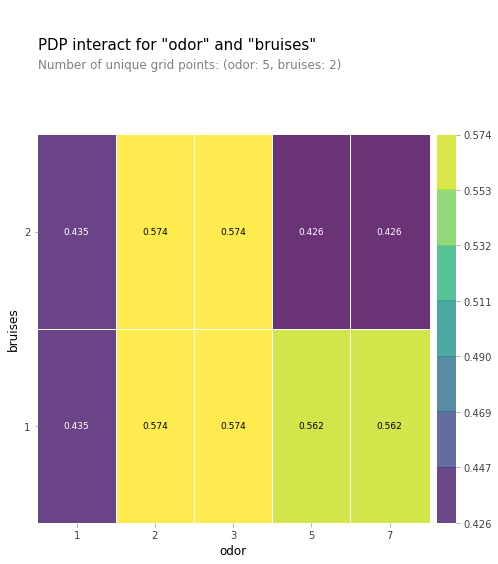

In [55]:
### PDP -> 2 features 

features = ['odor', 'bruises']


interaction = pdp_interact(model = xgb_model, dataset = X_val_encoded, model_features = X_val_encoded.columns, features = features)


pdp_interact_plot(interaction, plot_type = 'grid', feature_names = features)
plt.show()

**해석**  



(2) odor - population

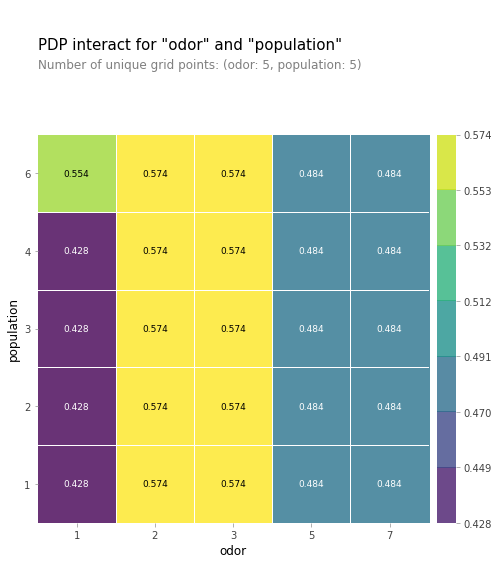

In [56]:
features = ['odor', 'population']

interaction = pdp_interact(model = xgb_model, dataset = X_val_encoded, model_features = X_val_encoded.columns, features = features)


pdp_interact_plot(interaction, plot_type = 'grid', feature_names = features)
plt.show()

(3) odor - spore-print-color

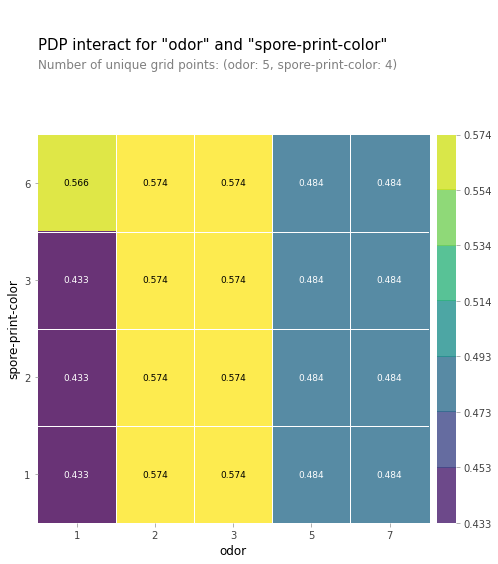

In [57]:
# PDP -> 2 features 

features = ['odor', 'spore-print-color']


interaction = pdp_interact(model = xgb_model, dataset = X_val_encoded, model_features = X_val_encoded.columns, features = features)




pdp_interact_plot(interaction, plot_type = 'grid', feature_names = features)
plt.show()

(4) bruises - population

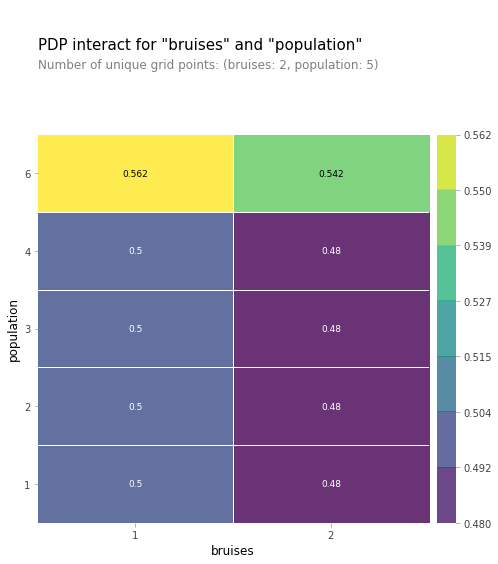

In [58]:
features = ['bruises', 'population']


interaction = pdp_interact(model = xgb_model, dataset = X_val_encoded, model_features = X_val_encoded.columns, features = features)


pdp_interact_plot(interaction, plot_type = 'grid', feature_names = features)
plt.show()

(5) bruises - spore-print-color

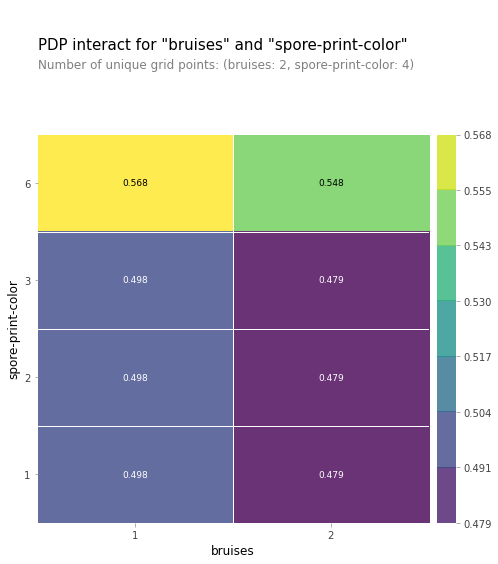

In [59]:
features = ['bruises', 'spore-print-color']


interaction = pdp_interact(model = xgb_model, dataset = X_val_encoded, model_features = X_val_encoded.columns, features = features)


pdp_interact_plot(interaction, plot_type = 'grid', feature_names = features)
plt.show()

(6) population - spore-print-color

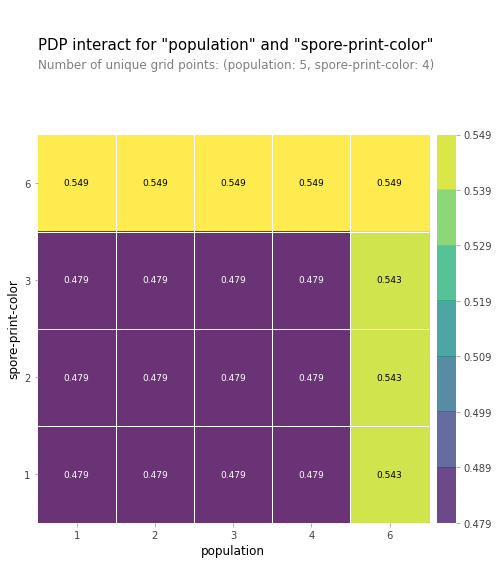

In [60]:
features = ['population', 'spore-print-color']


interaction = pdp_interact(model = xgb_model, dataset = X_val_encoded, model_features = X_val_encoded.columns, features = features)


pdp_interact_plot(interaction, plot_type = 'grid', feature_names = features)
plt.show()

### **5. 특성 변수의 기여도를 통한 최종 모델의 분류 예측 결과 설명**
- SHAP(SHapley Additive exPlanations) 적용  


자신이 권한 버섯은 결단코 독버섯이 아니라고 주장하는 4명의 용의자들!  
**그들이 제출한 버섯 증거물로 독버섯을 예측하라!**  
용의자들은 쉽사리 납득하지 않을 것입니다. 독버섯으로 예측된 이유에 관해 설명하세요.

#### **1) 용의자 1**

In [87]:
### SHAP -> samples of test data 

suspect_1 = X_test_encoded.iloc[[299]]

suspect_1

,bruises,odor,spore-print-color,population
915,2,6,3,6


In [88]:
### real value in y_test

y_test.iloc[[299]]


# 독버섯이 아니다.

915    0
Name: class, dtype: int64

In [89]:
### model prediction 

xgb_model.predict(suspect_1)


# 독버섯이 아니라고 예측했다.

array([0])

In [90]:
### reason of model prediction

explainer = shap.TreeExplainer(model = xgb_model)

shap_values = explainer.shap_values(suspect_1)


shap.initjs()
shap.force_plot(base_value = explainer.expected_value,
                shap_values = shap_values,
                features = suspect_1)

해석  
용의자 1은 자신이 먹인 버섯이 아몬드 냄새를 가졌다는 사실을 뒤늦게 자각하고 패닉상태였다.  
얼른 자신을 잡아가달라고 소란을 피우는 용의자 1을 진정시키느라 애를 먹을 정도였다.  
그러나 그의 자책감이 무색하게도 그는 범인이 아니었다.  
모델이 독버섯이 아니라고 예측한 이유는 무엇일까?
bruises	odor	spore-print-color	population
2	6	3	6
- 아몬드 냄새
- 외부 손상 시 타박상 혹은 멍으로 보이는 색상의 존재
- 갈색 버섯 포자 색상
- 많은 군집을 이루어 자랄 경우

그러나 그의 말과 달리 아몬드 냄새는 독버섯이 될 확률을 도리어 낮춰주고 있었다.<br>  
오히려 많은 군집을 이루어 자라는 이유가 독버섯이 될 확률에 아주 작게나마 기여하고 있었다.<br>
그럼에도 그가 먹인 버섯이 식용버섯이라는 점을 뒤바꿀 수 없는 미미한 기여였다. 
  


#### **2) 용의자 2**

In [104]:
suspect_2 = X_test_encoded.iloc[[1104]]

suspect_2

,bruises,odor,spore-print-color,population
5606,2,1,5,2


In [105]:
### real value of y_test

y_test.iloc[[1104]]

5606    0
Name: class, dtype: int64

In [106]:
### model prediction

xgb_model.predict(suspect_2)

array([0])

In [107]:
### reason of model prediction

explainer = shap.TreeExplainer(model = xgb_model)

shap_values = explainer.shap_values(suspect_2)


shap.initjs()
shap.force_plot(base_value = explainer.expected_value,
                shap_values = shap_values,
                features = suspect_2)

해석  
자신도 같이 먹었는데 왜 멀쩡하냐며 털 한끝조차 만지지 말라고 버럭버럭 소리지르듯 말하던 용의자2는 그 자신감답게 범인이 아니었다.  
그가 먹인 버섯은 과연 어땠을까?<br>
해당 버섯의 특징은 다음과 같았다.<br>
- 무취에 가까운 냄새
- 외부 손상 시 타박상 혹은 멍으로 보이는 색상의 존재  
- 하얀 버섯 포자 색상
- 서너개씩 자라나는 경우

그도 함께 먹은 버섯은 서너개씩 무리를 이루어 자라곤 하는 무취의 버섯이었다.  
그러나 그의 호언장담과 달리 그는 그저 운 좋은 사내일 뿐이었다.  
하얀색 포자색을 가지고 있는 버섯이었기 때문에 다소 독버섯이 될 확률이 꽤 높았기 때문이다.  
그러나 용의자1과 마찬가지로 독버섯은 아니었기 때문에 약간의 주의를 받고 용의선상에서 벗어날 수 있었다.

#### **3) 용의자 3**

In [69]:
suspect_3 = X_test_encoded.iloc[[3]]

suspect_3

,bruises,odor,spore-print-color,population
3924,2,1,3,2


In [70]:
### real value of y_test

y_test.iloc[[3]]

3924    0
Name: class, dtype: int64

In [71]:
### model prediction

xgb_model.predict(suspect_3)

array([0])

In [72]:
### reason of model prediction

explainer = shap.TreeExplainer(model = xgb_model)

shap_values = explainer.shap_values(suspect_3)


shap.initjs()
shap.force_plot(base_value = explainer.expected_value,
                shap_values = shap_values,
                features = suspect_3)

해석  
시끄럽던 다른 용의자들과 달리 말수 없이 담담히 땅만 보던 사내는 그가 풍기는 분위기처럼 깨끗히 용의선상에서 벗어났다.   
아무리 보아도 독버섯일 확률을 높이는 구석이라곤 찾아볼 수 없었기 때문이다.
- 무취에 가까운 냄새
- 외부 손상 시 타박상 혹은 멍으로 보이는 색상의 존재
- 갈색 버섯 포자 색상
- 서너개씩 자라나는 경우


#### 4**) 용의자 4**

In [95]:
suspect_4 = X_test_encoded.iloc[[174]]

suspect_4

,bruises,odor,spore-print-color,population
3282,1,3,1,2


In [96]:
### real value in y_test

y_test.iloc[[174]]

3282    1
Name: class, dtype: int64

In [97]:
### model prediction

xgb_model.predict(suspect_4)

array([1])

In [98]:
### reason of model prediction

explainer = shap.TreeExplainer(model = xgb_model)

shap_values = explainer.shap_values(suspect_4)


shap.initjs()
shap.force_plot(base_value = explainer.expected_value,
                shap_values = shap_values,
                features = suspect_4)

해석  
각 feature 가 모델의 독버섯 분류에 어떤 영향력을 끼치는지 설명할 때부터 안절부절 못하던 사내였다.  
역시나. 그가 피해자에게 먹인 버섯은 독버섯 그 자체였다.  
모델이 그가 범인이라고 밝힌 이유는 다음과 같다.
- 역한 타르 냄새(크레오소트)
- 외부 손상 시 타박상 혹은 멍의 결여
- 검정 버섯 포자 색상
- 서너개씩 자라나는 경우

언뜻 보기엔 평범한 버섯 같았지만 조금만 코를 가져다대도 역한 타르 냄새가 풍겨져 나왔다.<br>
독버섯으로 분류되기에 가장 강력한 냄새 중 하나인 코레오소트 냄새에도 어떻게 사내는 신입인 피해자에게 독버섯을 먹일 수 있었을까.<br>

